# Details

The notebook contains the synthetic data experiment with low noise (sigma^2 = 0.05). Due to the non-convexity of the HNCPD task, results will vary run to run, so the results from this notebook will not exactly match those in the paper.

In [1]:
# loading packages and functions
import sys

sys.path.append("./src")
import torch
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange

from utils import *
#
import torch.nn as nn
from torch.autograd import Variable
from writer import Writer

from sklearn.decomposition import NMF
from ssnmf import SSNMF

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac

In [2]:
from neural_nmf import Neural_NMF, Energy_Loss_Func, L21_Norm, Recon_Loss_Func
from neural_nmf import train_unsupervised, train_supervised
from neural_nmf import Writer

In [3]:
def HNMF(X, ranks, seed=0):
    
    model = NMF(n_components=ranks[0], init='random', random_state=seed, max_iter=300, solver='mu')
    A_1 = model.fit_transform(X)
    S_1 = model.components_

    model2 = NMF(n_components=ranks[1], init='random', random_state=seed, max_iter=300, solver='mu')
    A_2 = model2.fit_transform(S_1)
    S_2 = model2.components_

    model3 = NMF(n_components=ranks[2], init='random', random_state=seed, max_iter=300, solver='mu')
    A_3 = model3.fit_transform(S_2)
    S_3 = model3.components_
    
    return [A_1, A_2, A_3, S_1, S_2, S_3]

In [4]:
def measure_single(history, X, S_trues):
    
    A_1, A_2, A_3, S_1, S_2, S_3 = history
    
    results_topic = np.empty((3))

    results_topic[0] = measure_modeling(A_2 @ A_3, S_trues[0])
    results_topic[1] = measure_modeling(A_2, S_trues[1])
    results_topic[2] = measure_modeling(A_3, S_trues[2])


    approx_1 = A_1 @ S_1
    approx_2 = A_1 @ A_2 @ S_2
    approx_3 = A_1 @ A_2 @ A_3 @ S_3
    
    results_recon = np.asarray([recon_loss(X, approx_1), recon_loss(X, approx_2), recon_loss(X, approx_3)])
    
    return results_topic, results_recon

def measure_all(histories, X, S_trues):
    
    all_topic_losses = np.empty((3, len(histories)))
    all_recon_losses = np.empty((3, len(histories)))
    
    for i in range(len(histories)):
        topic_losses, recon_losses = measure_single(histories[i], X, S_trues)
        all_topic_losses[:,i] = topic_losses
        all_recon_losses[:,i] = recon_losses
        
    return all_topic_losses, all_recon_losses

## Generate Data Tensor

In [5]:
X = get_synthetic_tensor(seed=14, noise=0.4)
X_original = get_synthetic_tensor(noise=0)

### Visualize Original Data Tensor

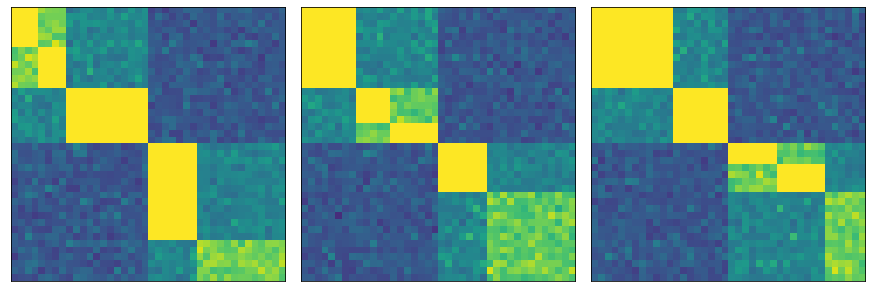

In [6]:
display_tensor(X)

In [7]:
X_flat = X.transpose((1,0,2)).reshape((40*40,-1)).T
X_flat_2 = X.transpose(2,0,1).reshape((40*40,-1)).T
X_flat_3 = X.transpose(2,1,0).reshape((40*40,-1)).T

X_flat_orig = X_original.transpose((1,0,2)).reshape((40*40,-1)).T
X_flat_2_orig = X_original.transpose(2,0,1).reshape((40*40,-1)).T
X_flat_3_orig = X_original.transpose(2,1,0).reshape((40*40,-1)).T

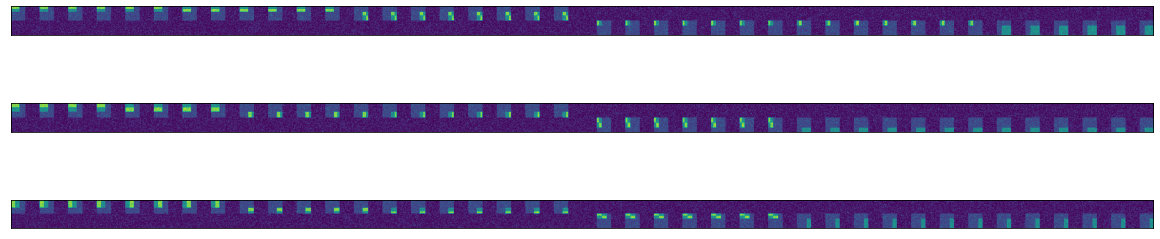

In [8]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(16,4))
axs[0].axes.get_xaxis().set_ticks([])
axs[0].axes.get_yaxis().set_ticks([])
axs[1].axes.get_xaxis().set_ticks([])
axs[1].axes.get_yaxis().set_ticks([])
axs[2].axes.get_xaxis().set_ticks([])
axs[2].axes.get_yaxis().set_ticks([])
axs[0].imshow(X_flat)
axs[1].imshow(X_flat_2)
axs[2].imshow(X_flat_3)
plt.show()

In [9]:
num_trials = 10
all_topic_losses = np.empty((3, 3 * num_trials))
all_recon_losses = np.empty((3, 3 * num_trials))
all_recon_losses_orig = np.empty((3, 3 * num_trials))

S_trues = get_synthetic_gt_topics()

for j, Xs in enumerate([(X_flat, X_flat_orig), (X_flat_2, X_flat_2_orig), (X_flat_3, X_flat_3_orig)]):
    X_temp = Xs[0]
    X_temp_orig = Xs[1]
    histories = []
    for i in range(num_trials):
        histories.append(HNMF(X_temp, [7,4,2], seed=i))
    
    topic_losses, recon_losses = measure_all(histories, X_temp, S_trues)   
    topic_losses, recon_losses_orig = measure_all(histories, X_temp_orig, S_trues)   
    
    all_topic_losses[:,num_trials*j:num_trials*(j+1)] = topic_losses
    all_recon_losses[:,num_trials*j:num_trials*(j+1)] = recon_losses  
    all_recon_losses_orig[:,num_trials*j:num_trials*(j+1)] = recon_losses_orig
    

In [10]:
for j in range(3):
    topic_losses = all_topic_losses[:,num_trials*j:num_trials*(j+1)]
    recon_losses = all_recon_losses[:,num_trials*j:num_trials*(j+1)] 
    handle_losses(recon_losses, topic_losses)
    print("-----------------------------")

Topic Modeling Loss 7 to 2 (average, best, worst): 0.1654322473420053 0.08540397863671008 0.2932419387519685
Topic Modeling Loss 7 to 4 (average, best, worst): 0.21945952842057337 0.13741867837291408 0.28545705049733044
Topic Modeling Loss 4 to 2 (average, best, worst): 0.13925315709048908 0.05364191092142204 0.24231219278907923

Relative Recon Loss Rank 7 (average, best, worst): 0.23728281964199455 0.2370590345486363 0.23754756450921272
Relative Recon Loss Rank 4 (average, best, worst): 0.30984592223968693 0.2856692958339384 0.3449655362624274
Relative Recon Loss Rank 2 (average, best, worst): 0.5137702003037209 0.4455498079939124 0.646912129612381
-----------------------------
Topic Modeling Loss 7 to 2 (average, best, worst): 0.15128148223094368 0.08684783593215892 0.32134683527351754
Topic Modeling Loss 7 to 4 (average, best, worst): 0.21300661788079395 0.1569806560274754 0.3181448599781236
Topic Modeling Loss 4 to 2 (average, best, worst): 0.08769624924472233 0.04122890087915537 0

In [11]:
handle_losses(all_recon_losses, all_topic_losses)

Topic Modeling Loss 7 to 2 (average, best, worst): 0.15136863769323014 0.0803130805625711 0.32134683527351754
Topic Modeling Loss 7 to 4 (average, best, worst): 0.20862756047521172 0.1264922033478564 0.3181448599781236
Topic Modeling Loss 4 to 2 (average, best, worst): 0.11371211736802955 0.04122890087915537 0.2557703195231416

Relative Recon Loss Rank 7 (average, best, worst): 0.23756905868764047 0.23688690713605615 0.23848360387205747
Relative Recon Loss Rank 4 (average, best, worst): 0.2968122991008096 0.27701229438399655 0.3449655362624274
Relative Recon Loss Rank 2 (average, best, worst): 0.5138177874023955 0.44182367802114847 0.6595822104749521


In [12]:
for j in range(3):
    topic_losses = all_topic_losses[:,num_trials*j:num_trials*(j+1)]
    recon_losses = all_recon_losses_orig[:,num_trials*j:num_trials*(j+1)] 
    handle_losses(recon_losses, topic_losses)
    print("-----------------------------")

Topic Modeling Loss 7 to 2 (average, best, worst): 0.1654322473420053 0.08540397863671008 0.2932419387519685
Topic Modeling Loss 7 to 4 (average, best, worst): 0.21945952842057337 0.13741867837291408 0.28545705049733044
Topic Modeling Loss 4 to 2 (average, best, worst): 0.13925315709048908 0.05364191092142204 0.24231219278907923

Relative Recon Loss Rank 7 (average, best, worst): 0.4724691733666229 0.47229862667298766 0.47262921833234767
Relative Recon Loss Rank 4 (average, best, worst): 0.524434799852324 0.49885496898587345 0.5635995783384016
Relative Recon Loss Rank 2 (average, best, worst): 0.7066651708114321 0.6608787598201561 0.7890241537176208
-----------------------------
Topic Modeling Loss 7 to 2 (average, best, worst): 0.15128148223094368 0.08684783593215892 0.32134683527351754
Topic Modeling Loss 7 to 4 (average, best, worst): 0.21300661788079395 0.1569806560274754 0.3181448599781236
Topic Modeling Loss 4 to 2 (average, best, worst): 0.08769624924472233 0.04122890087915537 0

In [13]:
handle_losses(all_recon_losses_orig, all_topic_losses)

Topic Modeling Loss 7 to 2 (average, best, worst): 0.15136863769323014 0.0803130805625711 0.32134683527351754
Topic Modeling Loss 7 to 4 (average, best, worst): 0.20862756047521172 0.1264922033478564 0.3181448599781236
Topic Modeling Loss 4 to 2 (average, best, worst): 0.11371211736802955 0.04122890087915537 0.2557703195231416

Relative Recon Loss Rank 7 (average, best, worst): 0.47224019853100013 0.4716567372613302 0.47282642795485447
Relative Recon Loss Rank 4 (average, best, worst): 0.510766218815301 0.49054488760863885 0.5635995783384016
Relative Recon Loss Rank 2 (average, best, worst): 0.7108082134730211 0.6513974330234672 0.8212196079393047


In [14]:
def run_neural_nmf(X, ranks):
    
    optimizer="gd"
    lr = 1e2

    epoch = 100
    weight_decay=0.998
    loss_func = Energy_Loss_Func() 

    net = Neural_NMF([40] + ranks)

    return train_unsupervised(net, torch.from_numpy(X), loss_func=loss_func, epoch = epoch, lr = lr, weight_decay=weight_decay, decay_epoch=5, optimizer=optimizer, full_history=True, verbose=False)

In [15]:
num_trials = 10
all_histories = []

all_topic_losses = np.empty((3, 3 * num_trials))
all_recon_losses = np.empty((3, 3 * num_trials))
all_recon_losses_orig = np.empty((3, 3 * num_trials))

for j, Xs in enumerate([(X_flat, X_flat_orig), (X_flat_2, X_flat_2_orig), (X_flat_3, X_flat_3_orig)]):
    X_temp = Xs[0]
    X_temp_orig = Xs[1]
    histories_neural = []
    for i in trange(num_trials):
        
        torch.manual_seed(i)
        history = run_neural_nmf(X_temp, [7,4,2])
        
        A_1 = history.get('A1')[-1].numpy()
        A_2 = history.get('A2')[-1].numpy()
        A_3 = history.get('A3')[-1].numpy()
        S_1 = history.get('S1')[-1].numpy()
        S_2 = history.get('S2')[-1].numpy()
        S_3 = history.get('S3')[-1].numpy()
        
        histories_neural.append([A_1, A_2, A_3, S_1, S_2, S_3])
        all_histories.append([A_1, A_2, A_3, S_1, S_2, S_3])
 
    topic_losses, recon_losses = measure_all(histories_neural, X_temp, S_trues)  
    topic_losses, recon_losses_orig = measure_all(histories_neural, X_temp_orig, S_trues)  

    all_topic_losses[:,num_trials*j:num_trials*(j+1)] = topic_losses
    all_recon_losses[:,num_trials*j:num_trials*(j+1)] = recon_losses  
    all_recon_losses_orig[:,num_trials*j:num_trials*(j+1)] = recon_losses_orig

100%|██████████| 10/10 [23:21<00:00, 140.11s/it]


In [16]:
for j in range(3):
    topic_losses = all_topic_losses[:,num_trials*j:num_trials*(j+1)]
    recon_losses = all_recon_losses[:,num_trials*j:num_trials*(j+1)] 
    handle_losses(recon_losses, topic_losses)
    print("-----------------------------")

Topic Modeling Loss 7 to 2 (average, best, worst): 0.1692825070879141 0.10053803943321628 0.22526198360776858
Topic Modeling Loss 7 to 4 (average, best, worst): 0.21841763069381842 0.15693290933343312 0.28191188162088177
Topic Modeling Loss 4 to 2 (average, best, worst): 0.12723348750781746 0.020600864932636215 0.22135746126320252

Relative Recon Loss Rank 7 (average, best, worst): 0.24339353432652905 0.23832839956200574 0.2524138302177525
Relative Recon Loss Rank 4 (average, best, worst): 0.3083236507021382 0.290747114964995 0.38005478044593566
Relative Recon Loss Rank 2 (average, best, worst): 0.5363894378630158 0.46818723670152584 0.595838834281101
-----------------------------
Topic Modeling Loss 7 to 2 (average, best, worst): 0.1528795686468438 0.10984246545858094 0.22721269458789756
Topic Modeling Loss 7 to 4 (average, best, worst): 0.18979342626154133 0.1337773525988545 0.25418809192505293
Topic Modeling Loss 4 to 2 (average, best, worst): 0.16038290048925616 0.06319770312710177

In [17]:
handle_losses(all_recon_losses, all_topic_losses)

Topic Modeling Loss 7 to 2 (average, best, worst): 0.15992409481087166 0.09514183829975789 0.2831497438745412
Topic Modeling Loss 7 to 4 (average, best, worst): 0.2015086056678967 0.09210580908881437 0.3153489776887876
Topic Modeling Loss 4 to 2 (average, best, worst): 0.14185685716742416 0.020600864932636215 0.24106958944095958

Relative Recon Loss Rank 7 (average, best, worst): 0.2420066219605625 0.23725449763066409 0.25348941665773655
Relative Recon Loss Rank 4 (average, best, worst): 0.30366971279789506 0.278537305327891 0.38005478044593566
Relative Recon Loss Rank 2 (average, best, worst): 0.5356247388890316 0.466676431627763 0.6489095931241914


In [18]:
for j in range(3):
    topic_losses = all_topic_losses[:,num_trials*j:num_trials*(j+1)]
    recon_losses = all_recon_losses_orig[:,num_trials*j:num_trials*(j+1)] 
    handle_losses(recon_losses, topic_losses)
    print("-----------------------------")

Topic Modeling Loss 7 to 2 (average, best, worst): 0.1692825070879141 0.10053803943321628 0.22526198360776858
Topic Modeling Loss 7 to 4 (average, best, worst): 0.21841763069381842 0.15693290933343312 0.28191188162088177
Topic Modeling Loss 4 to 2 (average, best, worst): 0.12723348750781746 0.020600864932636215 0.22135746126320252

Relative Recon Loss Rank 7 (average, best, worst): 0.47849070257961246 0.47217167604865234 0.4880881057981804
Relative Recon Loss Rank 4 (average, best, worst): 0.5212554353396144 0.5029178089598987 0.5865248293195875
Relative Recon Loss Rank 2 (average, best, worst): 0.7051048175020094 0.6695638331323606 0.7432931604693189
-----------------------------
Topic Modeling Loss 7 to 2 (average, best, worst): 0.1528795686468438 0.10984246545858094 0.22721269458789756
Topic Modeling Loss 7 to 4 (average, best, worst): 0.18979342626154133 0.1337773525988545 0.25418809192505293
Topic Modeling Loss 4 to 2 (average, best, worst): 0.16038290048925616 0.06319770312710177

In [19]:
handle_losses(all_recon_losses_orig, all_topic_losses)

Topic Modeling Loss 7 to 2 (average, best, worst): 0.15992409481087166 0.09514183829975789 0.2831497438745412
Topic Modeling Loss 7 to 4 (average, best, worst): 0.2015086056678967 0.09210580908881437 0.3153489776887876
Topic Modeling Loss 4 to 2 (average, best, worst): 0.14185685716742416 0.020600864932636215 0.24106958944095958

Relative Recon Loss Rank 7 (average, best, worst): 0.47652757279972574 0.4720614223921132 0.4880881057981804
Relative Recon Loss Rank 4 (average, best, worst): 0.5152706570672501 0.48989488946233023 0.5865248293195875
Relative Recon Loss Rank 2 (average, best, worst): 0.7026244241445923 0.661468227060382 0.7664403221373705
